# Import Libraries

In [ ]:
import torch
from torch.utils.data import DataLoader
import os
from utils import *
import matplotlib.pyplot as plt
import numpy as np
import yaml
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, confusion_matrix
import transformers
from transformers import BertConfig

time: 3.14 s (started: 2023-07-24 00:21:41 +00:00)


# Load a model that's already been trained

In [ ]:
# please make sure that CONFIG is the same one used to generate the loaded model
CONFIG = 'bert_1.yml'
# please adjust the path of the .pth file
model_pthFile = 'models/1689900332_053097.pth'

MACHINE_USED = 'josephs_colab'

time: 554 µs (started: 2023-07-24 00:24:27 +00:00)


In [ ]:
def pick_device(config):
    if config['device'] == 'gpu':
        if torch.cuda.is_available():
            device_type = "cuda"
        else:
            device_type = "cpu"
        print(f"using device type: {device_type}")
        device = torch.device(device_type)
    return device

time: 686 µs (started: 2023-07-24 00:22:05 +00:00)


In [ ]:
MODEL_METADATA_FILENAME = 'model_metadata.csv'
# load data
with open(os.path.join('configs', CONFIG),'r') as file:
        config = yaml.safe_load(file)
print('config:')
print(config)

device = pick_device(config)
torch.cuda.empty_cache()

tokenizer, model, optimizer = load_model(config['bert_type'], float(config['learning_rate']), 0, device)

data = load_data('data', config['data_file'])
train_data_loader, test_data_loader = process_data(data, tokenizer, test_size=config['test_data_pct'], max_len=config['max_len'], batch_size=config['batch_size'])

config:
{'test_data_pct': 0.8, 'learning_rate': '1e-4', 'bert_type': 'tinybert', 'epochs': 9, 'batch_size': 64, 'max_len': 150, 'dropout': 0, 'fraction': 1.0, 'device': 'gpu', 'data_file': '/content/drive/MyDrive/DL Summer 23/data/shuffled_data.csv'}
using device type: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


time: 4.48 s (started: 2023-07-24 00:24:33 +00:00)


In [ ]:
# load trained model .pth
loaded_state = torch.load(model_pthFile)
loaded_state_dict = loaded_state.state_dict()

if isinstance(loaded_state_dict, dict):
    print("loaded_state_dict is dictionary-like.")
else:
    print("loaded_state_dict is not dictionary-like.")

model.load_state_dict(loaded_state_dict)

model.eval()

loaded_state_dict is dictionary-like.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, ele

time: 44.3 ms (started: 2023-07-24 00:24:44 +00:00)


# Perform Post-processing

## Calculate test accuracy (skip this if you want to go straight to SHAP)

In [ ]:
def evaluate(model, data_loader, device):
    model_eval = model.eval()
    correct = 0
    total = 0

    predictions = []
    labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            local_labels = batch["labels"].to(device)

            outputs = model_eval(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, local_predictions = torch.max(outputs.logits, dim=1)

            correct += torch.sum(local_predictions == local_labels)
            total += local_labels.shape[0]

            predictions.extend(local_predictions)
            labels.extend(local_labels)


    accuracy = correct/total

    return accuracy.item()

time: 1.03 ms (started: 2023-07-24 00:24:49 +00:00)


In [ ]:
accuracies = {}
accuracies['initial test'] = evaluate(model, test_data_loader, device)

time: 15min 22s (started: 2023-07-24 00:24:53 +00:00)


In [ ]:
print(accuracies['initial test'])

0.623995840549469
time: 499 µs (started: 2023-07-24 00:40:16 +00:00)


## Implmenet SHAP

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

def generate_shap_values(model, tokenizer, device, data_loader):
    """
    Generates shap values using the first batch of data from the data_loader.
    Inputs:
    - model
    - tokenizer
    - device
    - data loader
    Outputs:
    - shap_values: shape is (batch size x None x num_classes) where num_classes = 2 for binary classification
    - explainer: shap explainer object
    - texts: list of input texts from the first batch samples from the data loader
    """
    # define a prediction function
    def f(x):
        model.eval()
        with torch.no_grad():
            input_ids = torch.tensor([tokenizer.encode(text, padding='max_length', max_length=200, truncation=True) for text in x]).to(device)
            attention_mask = (input_ids != 0).to(device)  # Create attention mask to ignore padding tokens
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits.detach().cpu().numpy()
        model.train()
        return logits

    # Build an explainer using a token masker
    explainer = shap.Explainer(f, tokenizer)

    # Explain the model's predictions on the data_loader data
    subset_data = next(iter(data_loader))  # Replace this with the subset of the data or pass the entire data_loader
    texts = subset_data['text']  # Assuming your data has a 'text' key

    shap_values = explainer(texts, fixed_context=1)

    return shap_values, explainer, texts

def generate_shap_viz_instance(shap_values, texts, explainer, sample_index, sample_class):
    """
    Generates two shap visuals for a single instance specified via 'sample_index'.
    Inputs:
    - shap_values
    - texts
    - explainer
    - sample_index: the index of the sample to generate visuals for (integer 0-63 if batch size is 64)
    - sample_class: 1 for AI-text prediction, 0 for human-text predictions
    """
    # Get the tokens for the current sample
    tokens_sample = tokenizer.tokenize(texts[sample_index])

    # Get the SHAP values for the specified sample in the specified class
    shap_values_sample = shap_values[sample_index, :, sample_class]

    # Generate a bar chart
    plt.figure()
    shap.plots.bar(shap_values_sample, max_display=15, order=shap.Explanation.argsort.flip)

    # Generate a text plot
    shap.plots.text(shap_values_sample)

def generate_shap_viz_summary(shap_values, texts, explainer, sample_class, min_instances=10, max_tokens=50):
    """
    Generates a shap summary plot for all instances.
    Inputs:
    - shap_values
    - texts
    - explainer
    - sample_class: 1 for AI-text prediction, 0 for human-text predictions
    - max_tokens: maximum number of tokens to display in the summary plot
    """
    # Get the SHAP values for the specified class across all samples
    shap_values_class = shap_values[:, :, sample_class]

    shap_values_class_flat = [value for value in shap_values_class]

    # Convert the texts to tokens
    tokens = [tokenizer.tokenize(text) for text in texts]

    # Aggregate the SHAP values at the token level across all instances
    token_values = defaultdict(list)
    for token_list, value_list in zip(tokens, shap_values_class_flat):
        # Extract the SHAP values from the Explanation object
        shap_values = value_list.values[:-2]  # Exclude the last two elements
        for token, value in zip(token_list, shap_values):
            token_values[token].append(value)

    # Filter out tokens that appear in fewer than min_instances instances
    token_values = {token: values for token, values in token_values.items() if len(values) >= 10}

    # Select the top tokens and their corresponding SHAP values
    top_tokens, top_shap_values = zip(*sorted(token_values.items(), key=lambda x: abs(np.mean(x[1])), reverse=True)[:max_tokens])

    # Pad the SHAP values to create a regular 2D array
    max_len = max(len(values) for values in top_shap_values)
    top_shap_values = np.array([values + [0] * (max_len - len(values)) for values in top_shap_values])

    # Transpose the top_shap_values array
    top_shap_values = top_shap_values.T

    # Generate a summary plot
    shap.summary_plot(top_shap_values, feature_names=top_tokens)






time: 1.61 s (started: 2023-07-24 00:44:12 +00:00)


In [ ]:
shap_values, explainer, texts = generate_shap_values(model, tokenizer, device, train_data_loader)

Partition explainer: 65it [02:40,  2.63s/it]


time: 2min 40s (started: 2023-07-24 00:44:15 +00:00)


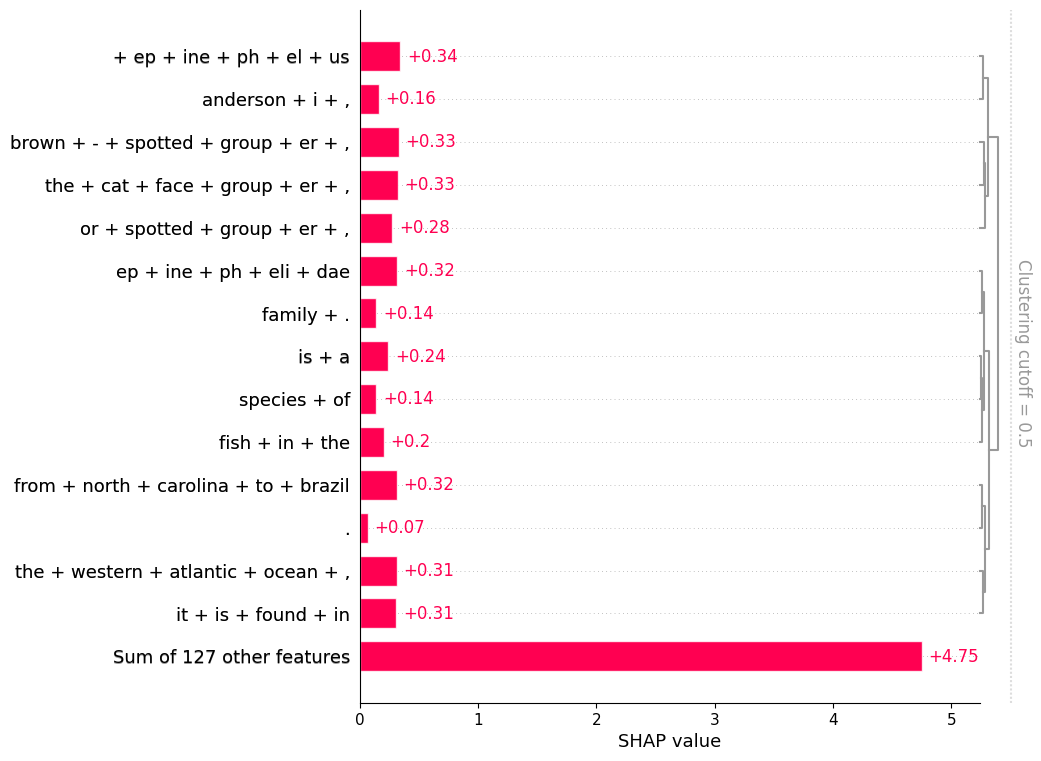

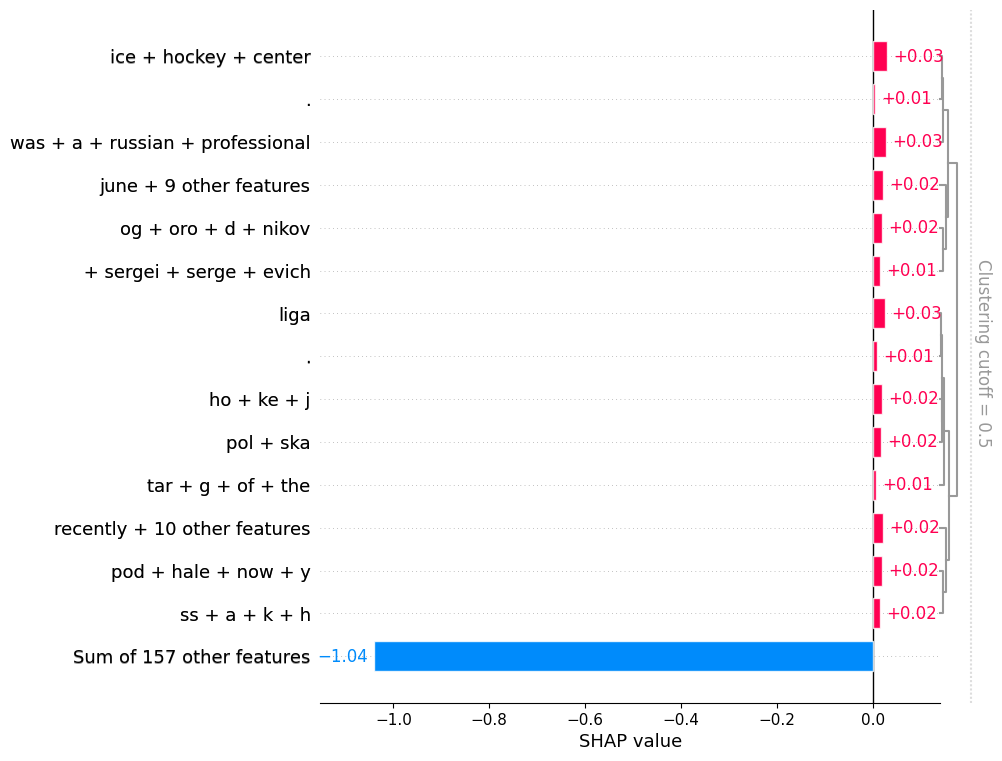

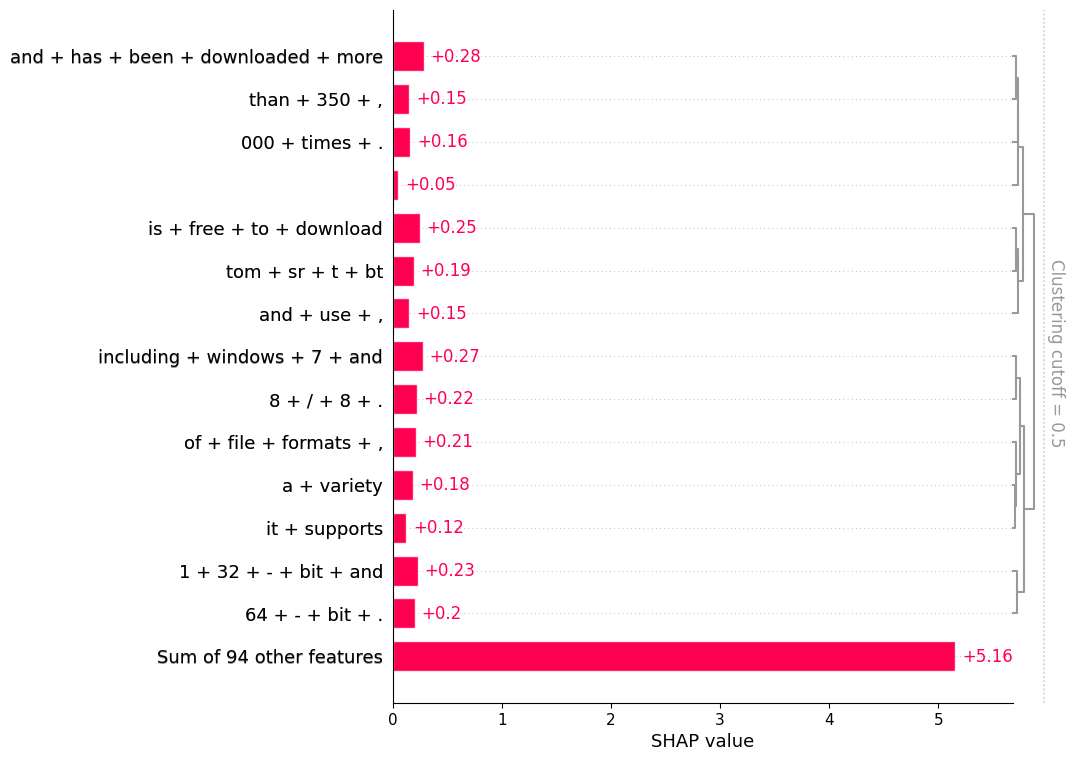

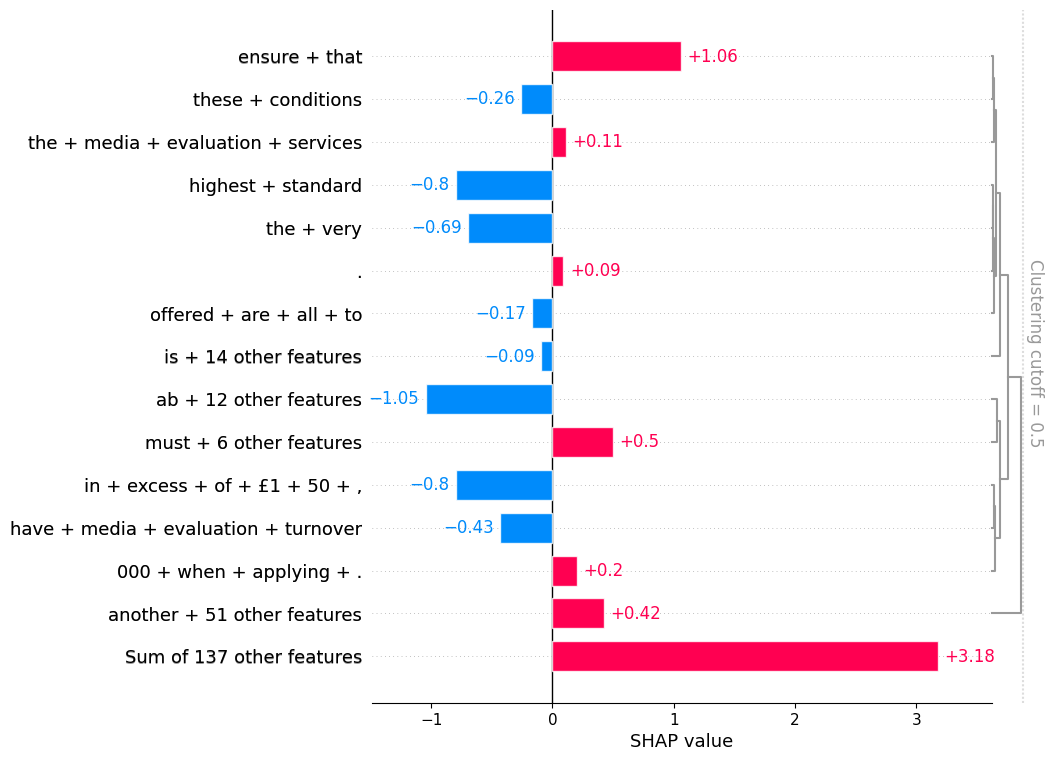

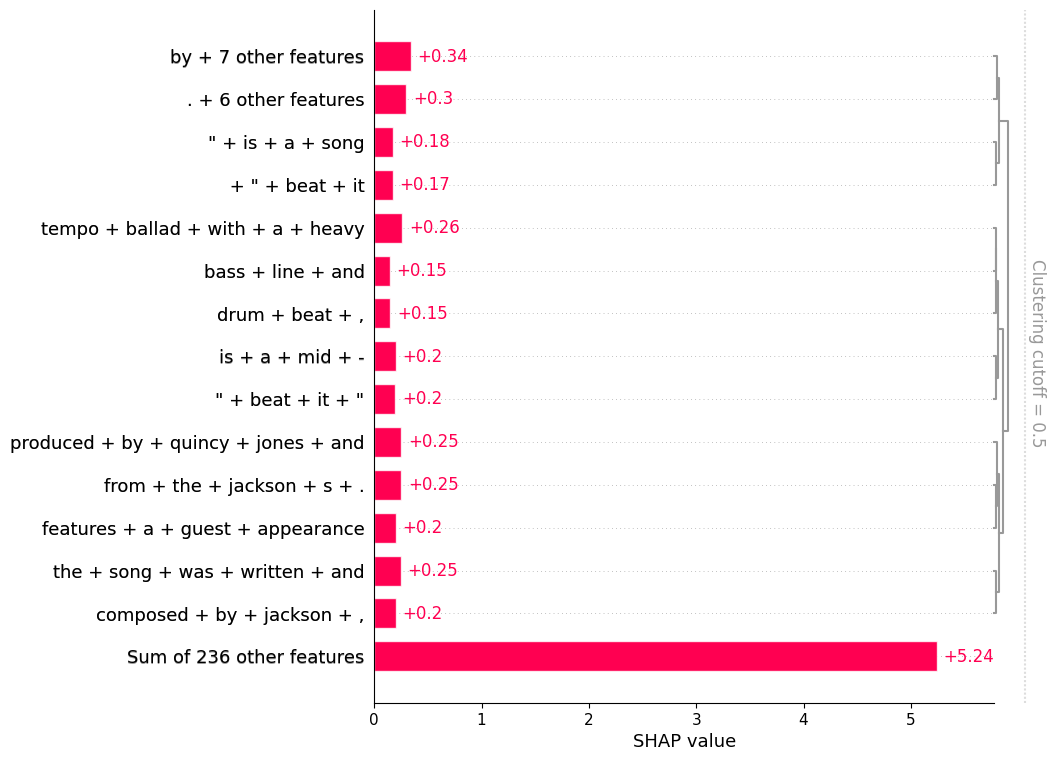

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


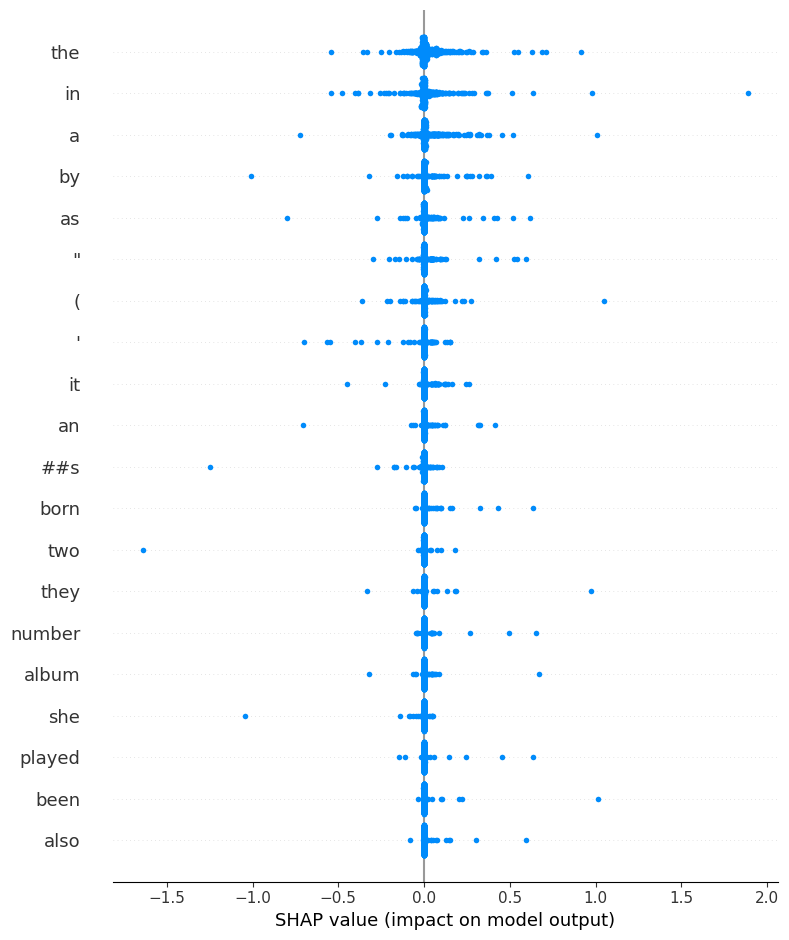

time: 13.8 s (started: 2023-07-24 00:47:02 +00:00)


In [ ]:
sample_index = 0  # index of the sample to generate visuals for (integer 0-63 if batch size is 64)
sample_class = 1  # 1 for AI-text prediction, 0 for human-text predictions

# Generate feature importance plots for the first 5 instances in the batch
generate_shap_viz_instance(shap_values, texts, explainer, sample_index, sample_class)
sample_index = 1
generate_shap_viz_instance(shap_values, texts, explainer, sample_index, sample_class)
sample_index = 2
generate_shap_viz_instance(shap_values, texts, explainer, sample_index, sample_class)
sample_index = 3
generate_shap_viz_instance(shap_values, texts, explainer, sample_index, sample_class)
sample_index = 4
generate_shap_viz_instance(shap_values, texts, explainer, sample_index, sample_class)

# generate an overall feature importance plot
generate_shap_viz_summary(shap_values, texts, explainer, sample_class)